# **Modelos 3D para imágenes**

In [1]:
import os, torch
from torch.utils.data import Dataset
from sklearn.model_selection import GroupShuffleSplit
import numpy as np
import pandas as pd
from pathlib import Path

In [2]:
# === Directorios ===
OUT_DIR = Path(r"C:\Users\Hp\MACHINE\MRI\datos\procesadas")
df = pd.read_csv(r"C:\Users\Hp\MACHINE\MRI\notebooks\Data\atributos.csv")

In [3]:
# --- Revisar valores nulos ---
print("\nNulos por columna principal:")
print(df[["is_dementia", "label_progresion"]].isna().sum())


Nulos por columna principal:
is_dementia         28
label_progresion     0
dtype: int64



📊 Distribución de la variable objetivo:
label_progresion
0    54.84
1    45.16
Name: proportion, dtype: float64


<Axes: title={'center': 'Distribución de progresión'}, xlabel='label_progresion'>

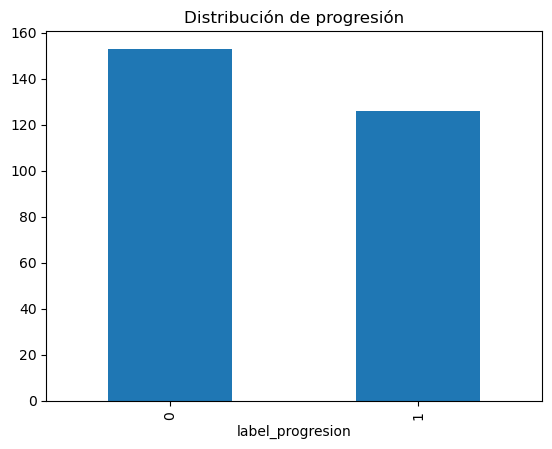

In [ ]:
# === 1️⃣ Balance de clases ===
print("\n Distribución de la variable objetivo:")
print(df["label_progresion"].value_counts(normalize=True).mul(100).round(2))
df["label_progresion"].value_counts().plot(kind="bar", title="Distribución de progresión")


In [5]:
# === 3️⃣ División 75/15/15 por sujeto ===
groups = df["sujeto_id"]

gss1 = GroupShuffleSplit(test_size=0.30, n_splits=1, random_state=42)
train_idx, temp_idx = next(gss1.split(df, groups=groups))
train_df, temp_df = df.iloc[train_idx], df.iloc[temp_idx]

# ahora dividimos temp en validación y test (15/15)
gss2 = GroupShuffleSplit(test_size=0.50, n_splits=1, random_state=42)
val_idx, test_idx = next(gss2.split(temp_df, groups=temp_df["sujeto_id"]))
val_df, test_df = temp_df.iloc[val_idx], temp_df.iloc[test_idx]

print("\n📂 Tamaños del split:")
print(f"Entrenamiento: {len(train_df)}")
print(f"Validación:   {len(val_df)}")
print(f"Prueba:       {len(test_df)}")


📂 Tamaños del split:
Entrenamiento: 190
Validación:   45
Prueba:       44


In [6]:
# === 4️⃣ Preparar X y y ===
X_train = train_df["ruta_npy"].values
y_train = train_df["label_progresion"].values.astype(np.float32)

X_val   = val_df["ruta_npy"].values
y_val   = val_df["label_progresion"].values.astype(np.float32)

X_test  = test_df["ruta_npy"].values
y_test  = test_df["label_progresion"].values.astype(np.float32)

print("\n✅ Variables listas:")
print(f"X_train: {len(X_train)} rutas")
print(f"y_train: {np.bincount(y_train.astype(int))} clases (balance)")


✅ Variables listas:
X_train: 190 rutas
y_train: [ 74 116] clases (balance)


In [ ]:
class MRIDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = np.load(row["ruta_npy"]).astype(np.float32)
        img = np.expand_dims(img, axis=0)  # canal único [1, D, H, W]
        label = torch.tensor(row["label_progresion"], dtype=torch.float32)
        if self.transform:
            img = self.transform(img)
        return torch.tensor(img), label

In [ ]:
splitter = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
train_idx, test_idx = next(splitter.split(df, groups=df["sujeto_id"]))
train_df, test_df = df.iloc[train_idx], df.iloc[test_idx]